In [2]:
import matplotlib
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix
from sklearn import tree
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
import pickle
from collections import Counter
from util import *

In [3]:
with open('plot_data.pickle', 'rb') as handle:
    plot_data = pickle.load(handle)

# Abstract
In this project I tried to predict the movie genre. The prediction is based on users ratings and information about other movie genres.
## The data
The data comes from movielens database (https://grouplens.org/datasets/movielens/). There are two tables: `ratings` and `movies`.
In table `ratings` there are users ratings of movies. It contain 4 columns: `userId`, `movieId`, `rating` and `timestamp`:

In [6]:
ratings, movies, genres = read_files()
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


The `movies` table contains information about the movies. It has movie id, the movie title and a movie genres bag of words.
It wasn't very useful, so I have converted it into boolean vector - each genre has each own column. I've also added each movie's mean rating.

In [7]:
movies.head()

,movieId,title,genres,Children,Adventure,Sci-Fi,Western,Comedy,Documentary,Thriller,...,War,Animation,Film-Noir,Crime,Drama,Romance,IMAX,Action,Musical,mean
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,True,True,False,False,True,False,False,...,False,True,False,False,False,False,False,False,False,3.920930
1,2,Jumanji (1995),Adventure|Children|Fantasy,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,3.431818
2,3,Grumpier Old Men (1995),Comedy|Romance,False,False,False,False,True,False,False,...,False,False,False,False,False,True,False,False,False,3.259615
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,False,False,False,False,True,False,False,...,False,False,False,False,True,True,False,False,False,2.357143
4,5,Father of the Bride Part II (1995),Comedy,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,3.071429


## Training data
To get useful training data I had to create an utility matrix: the rows are users, the columns are movies.
The single cell is a rating of movie by user, 0 if there was not such a rating. 

In [8]:
utility_matrix = coo_matrix((ratings['rating'], (ratings['userId'], ratings['movieId']))).asfptype()

Finally I combined the ratings, mean rating and the movies genres together:

In [9]:
utility_matrix = coo_matrix((ratings['rating'], (ratings['userId'], ratings['movieId']))).asfptype()
Tree_data = pd.DataFrame(
        data=utility_matrix.toarray()[:, movies["movieId"]].T,
        columns=[f"user_{x}" for x in range(utility_matrix.shape[0])]
)
Tree_data[list(genres)] = movies[list(genres)]
Tree_data['mean'] = movies['mean']
Tree_data = Tree_data.fillna(0)
Tree_data.head()

,user_0,user_1,user_2,user_3,user_4,user_5,user_6,user_7,user_8,user_9,...,War,Animation,Film-Noir,Crime,Drama,Romance,IMAX,Action,Musical,mean
0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,...,False,True,False,False,False,False,False,False,False,3.920930
1,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,...,False,False,False,False,False,False,False,False,False,3.431818
2,0.0,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,...,False,False,False,False,False,True,False,False,False,3.259615
3,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,False,False,False,False,True,True,False,False,False,2.357143
4,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,3.071429


# Learning approaches 
## Training
For every movie genre I remove it's column from the dataset and then I make a cross-validation training. The final score is a mean cross-validation score.
## First try - DecisionTreeClassifier
I decided to try many different classifiers. At first I have tried the decision tree classifier with different 
parameters - I've tuned the `max_depth`, `min_samples_split`, `min_samples_leaf`, `min_impurity_decrease` and `class_weight` parameters. 
We will have the best one as a base comparison.

In [ ]:
tmp_genres = list(genres)
plot_data["DecisionTreeClassifier"] = test_classifier(
        tree.DecisionTreeClassifier,
        Tree_data,
        tmp_genres,
        axs=axs,
        verbose=False,
        plot=False,
        max_depth=30, 
        min_samples_split=20, 
        min_samples_leaf=10, 
        min_impurity_decrease=0.0001,
        n_jobs=-1,
        class_weight='balanced'
)
with open('plot_data.pickle', 'wb') as handle:
    pickle.dump(plot_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

The results are on the plot. The X axis is a number of movies of specific genre, the Y axis is a mean cross-validation score.

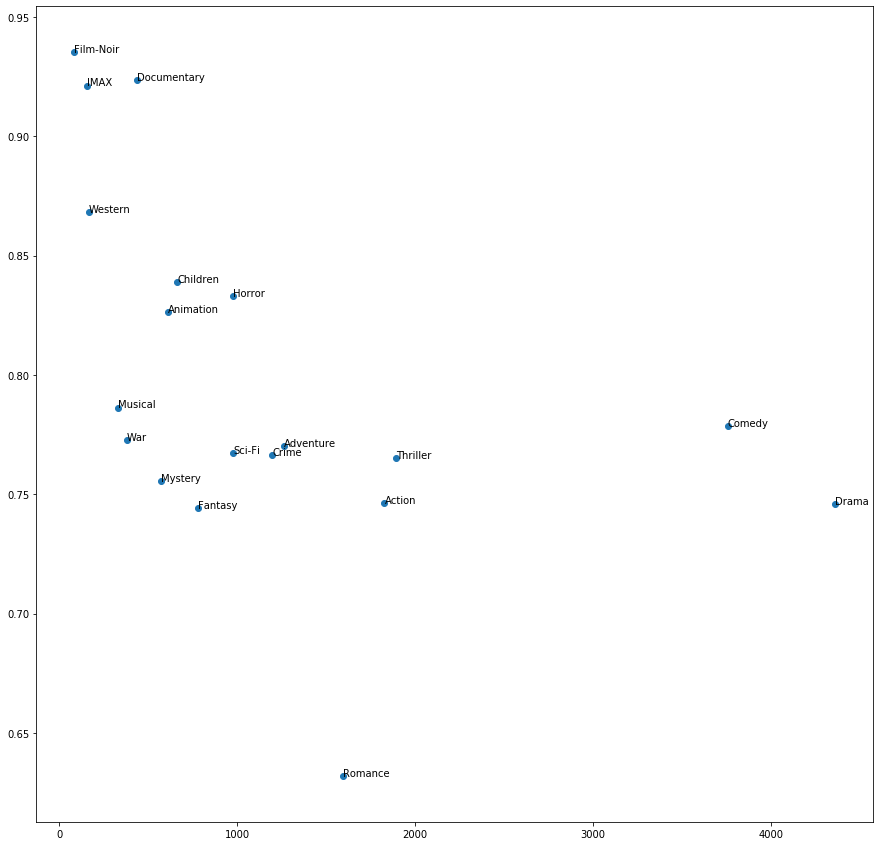

In [4]:
plot_results(plot_data["DecisionTreeClassifier"], plt.subplots(figsize=(15, 15)), "DecisionTreeClassifier")

## RandomForestClassifier
The second classifier was random forest. Random forest is a meta estimator that fits a number of decision tree
classifiers on various sub-samples of the dataset and uses averaging to
improve the predictive accuracy and control over-fitting. I have experimented with different values of parameters: `max_depth`, `n_estimators` and `max_features`.

In [ ]:
for i in [5, 10, 50, 100]:
    name = f"RandomForest_max_depth_{i}"
    plot_data[name]=test_classifier(
            RandomForestClassifier,
            Tree_data,
            tmp_genres,
            clf_name=name,
            axs=axs,
            verbose=False,
            plot=False,
            max_depth=i,
            random_state=7,
            max_features=5,
            n_estimators=100,
            n_jobs=-1,
            class_weight="balanced"
    )
    with open('plot_data.pickle', 'wb') as handle:
        pickle.dump(plot_data, handle, protocol=pickle.HIGHEST_PROTOCOL)



for i in tqdm([10, 50, 100, 500, 1000]):
    name = f"RandomForest_n_estimators_{i}"
    plot_data[name]=test_classifier(
            RandomForestClassifier,
            Tree_data,
            tmp_genres,
            clf_name=name,
            axs=axs,
            verbose=False,
            plot=False,
            max_depth=50,
            random_state=7,
            max_features=9,
            n_estimators=i,
            n_jobs=-1,
            class_weight="balanced"
    )
    with open('plot_data.pickle', 'wb') as handle:
        pickle.dump(plot_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

    
for i in tqdm([7, 8, 9, 10, 11, 15, 20, 50]):
    name = f"RandomForest_max_features_{i}"
    plot_data[name]=test_classifier(
            RandomForestClassifier,
            Tree_data,
            tmp_genres,
            clf_name=name,
            axs=axs,
            verbose=False,
            plot=False,
            max_depth=50,
            random_state=7,
            max_features=i,
            n_jobs=-1,
            n_estimators=100,
            class_weight="balanced"
    )
    with open('plot_data.pickle', 'wb') as handle:
        pickle.dump(plot_data, handle, protocol=pickle.HIGHEST_PROTOCOL)



In [ ]:
tmp_genres = list(genres)
name = f"RandomForest_max_features_20_n_estimators_100_max_depth_50"
plot_data[name]=test_classifier(
        RandomForestClassifier,
        Tree_data,
        tmp_genres,
        clf_name=name,
        axs=axs,
        verbose=False,
        plot=False,
        max_depth=50,
        random_state=7,
        max_features=20,
        n_jobs=-1,
        n_estimators=100,
        class_weight="balanced"
)
with open('plot_data.pickle', 'wb') as handle:
    pickle.dump(plot_data, handle, protocol=pickle.HIGHEST_PROTOCOL)



The results are much better then a decision tree classifier. To make a plot clearer there are only results no worse then 99% of best one

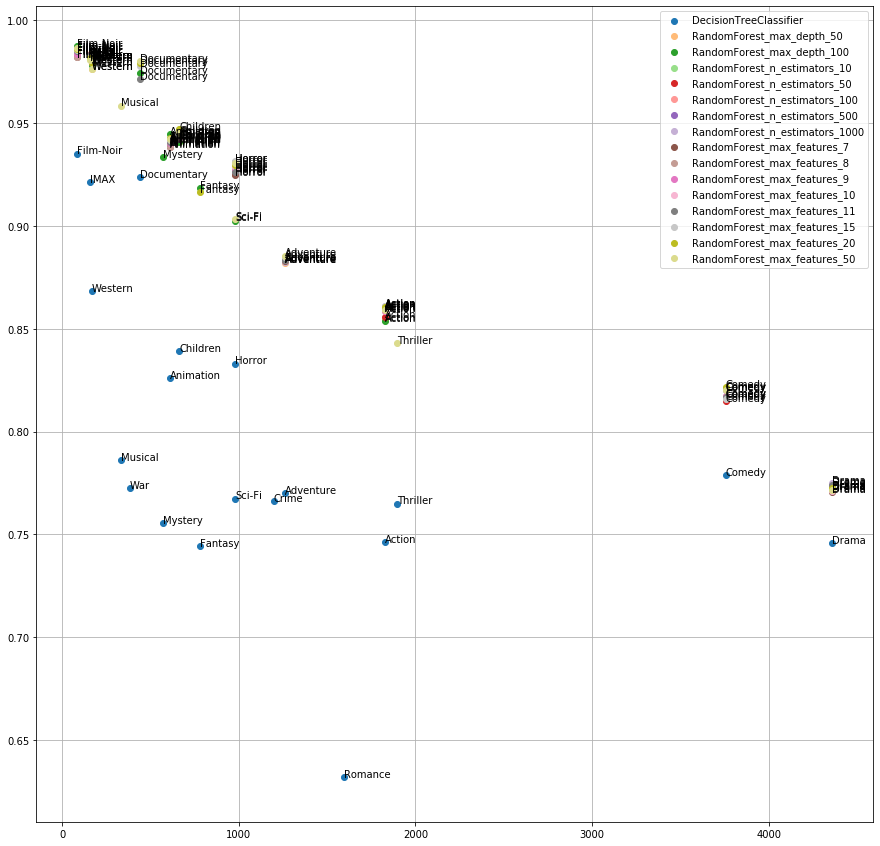

In [27]:
axs = plt.subplots(figsize=(15, 15))
cmap = matplotlib.cm.get_cmap('tab20')
best = {g:np.max([plot_data[test][g][1] for test in plot_data]) for g in genres}

i = 0
for name in plot_data:
    # if "max_depth" not in name and "max_features" not in name:
    if "RandomForest" in name and name != "RandomForest_max_features_20_n_estimators_100_max_depth_50":
        chosen_data = {
            g: plot_data[name][g] 
            for g in plot_data[name] 
            if np.abs(plot_data[name][g][1] - best[g]) / best[g] < 0.01
        }
        i += 1

    elif "Tree" in name:
        chosen_data = plot_data[name]
    else:
        continue
    color = cmap(i/20.)
    if len(chosen_data) > 0:
        plot_results(chosen_data, axs, name, color=[color])

axs[1].legend()
axs[1].grid(True)

best_cls = {
    g: sorted(
        [
            (name, plot_data[name][g][1])
            for name in plot_data 
            if np.abs(plot_data[name][g][1] - best[g]) / best[g] < 0.01 \
            and "RandomForest" in name and name != "RandomForest_max_features_20_n_estimators_100_max_depth_50"
        ], 
        key=lambda x: x[1]
    )[::-1]
    for g in genres
}


Each classifier also got points for being in best classifiers for each genres: here are the results:

In [28]:
counted = Counter(
    [c[0]
        for  g in best_cls
        for c in best_cls[g]
    ]
)
counted = {k: v for k, v in sorted(counted.items(), key=lambda item: item[1], reverse=True)}
for key in counted:
    print(f"{counted[key]} - {key}")

14 - RandomForest_max_features_50
11 - RandomForest_max_features_20
11 - RandomForest_max_features_11
11 - RandomForest_max_features_15
11 - RandomForest_max_depth_100
10 - RandomForest_n_estimators_1000
9 - RandomForest_max_features_9
9 - RandomForest_n_estimators_100
9 - RandomForest_n_estimators_500
9 - RandomForest_max_features_7
9 - RandomForest_max_features_8
8 - RandomForest_max_features_10
8 - RandomForest_n_estimators_50
5 - RandomForest_max_depth_50
1 - RandomForest_n_estimators_10


In this plot we have a comparision between the classifier which has the beat features and the best classifier for each category:

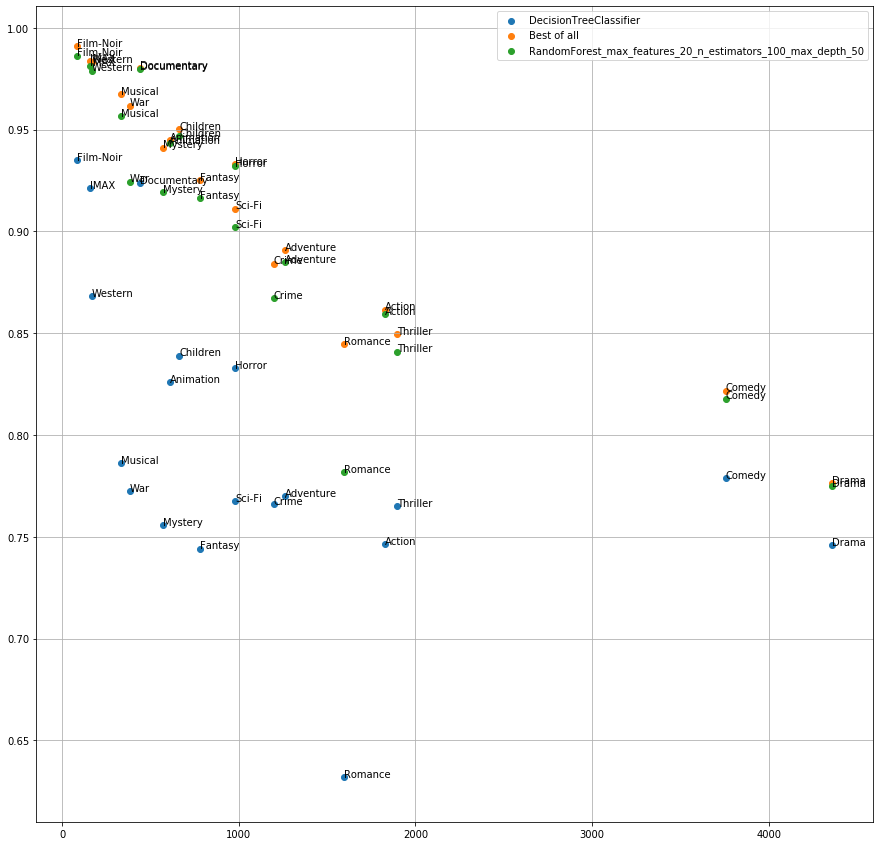

In [12]:
axs = plt.subplots(figsize=(15, 15))
plot_results(plot_data["DecisionTreeClassifier"], axs, "DecisionTreeClassifier")
plot_results(
    {
        g: [plot_data["DecisionTreeClassifier"][g][0], best_cls[g][0][1]]
        for g in best_cls
    }, axs, "Best of all"
)
plot_results(plot_data["RandomForest_max_features_20_n_estimators_100_max_depth_50"], axs, "RandomForest_max_features_20_n_estimators_100_max_depth_50")
axs[1].legend()
axs[1].grid(True)
plt.show()

## RandomForestRegressor
As an experiment I have tried an RandomForestRegressor:

In [ ]:

for i in tqdm([5, 10, 50, 100]):
    name = f"RandomForestRegressor_max_depth_{i}"
    plot_data[name]=test_classifier(
            RandomForestRegressor,
            Tree_data,
            tmp_genres,
            clf_name=name,
            axs=axs,
            verbose=False,
            plot=False,
            max_depth=i,
            random_state=7,
            max_features=5,
            n_estimators=100,
            n_jobs=4,
    )
    with open('plot_data.pickle', 'wb') as handle:
        pickle.dump(plot_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

for i in tqdm([10, 50, 100, 500, 1000]):
    name = f"RandomForestRegressor_n_estimators_{i}"
    plot_data[name]=test_classifier(
            RandomForestRegressor,
            Tree_data,
            tmp_genres,
            clf_name=name,
            axs=axs,
            verbose=False,
            plot=False,
            max_depth=50,
            random_state=7,
            max_features=9,
            n_estimators=i,
            n_jobs=4,
    )
    with open('plot_data.pickle', 'wb') as handle:
        pickle.dump(plot_data, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
for i in tqdm([7, 8, 9, 10, 11, 15, 20, 50]):
    name = f"RandomForestRegressor_max_features_{i}"
    plot_data[name]=test_classifier(
            RandomForestRegressor,
            Tree_data,
            tmp_genres,
            clf_name=name,
            axs=axs,
            verbose=False,
            plot=False,
            max_depth=50,
            random_state=7,
            max_features=i,
            n_jobs=4,
            n_estimators=100,
    )
    with open('plot_data.pickle', 'wb') as handle:
        pickle.dump(plot_data, handle, protocol=pickle.HIGHEST_PROTOCOL)



It is not a surprise - it is much, much worse than everything I tried before:

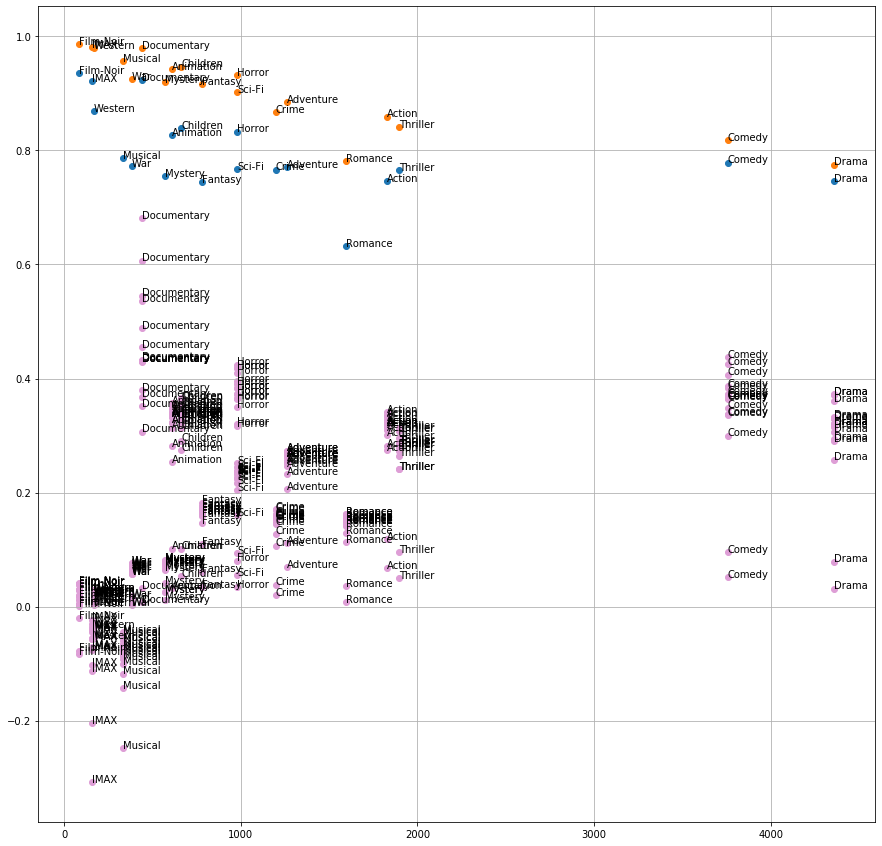

In [39]:
axs = plt.subplots(figsize=(15, 15))
cmap = matplotlib.cm.get_cmap('tab20b')

plot_results(plot_data["DecisionTreeClassifier"], axs, "DecisionTreeClassifier")
plot_results(plot_data["RandomForest_max_features_20_n_estimators_100_max_depth_50"], axs, "RandomForest_max_features_20_n_estimators_100_max_depth_50")


for i, name in enumerate(plot_data):
    if "RandomForestRegressor" in name:
        color = cmap(i/20.)
        plot_results(plot_data[name], axs, name, color=[color])


# axs[1].legend()
axs[1].grid(True)

## MultinomialNB
I have tested MultinomialNB for many different alphas from 0.1 to 20000:

In [ ]:
for alpha in tqdm([0.1, 0.5, 0.7, 0.9, 1, 1.5, 2, 5, 10, 100, 150, 500, 1000, 5000, 20000]):
    for fit_prior in [True, False]:
        name = f"MultinomialNB_alpha_{alpha}_fit_prior_{fit_prior}"
        plot_data[name]=test_classifier(
                MultinomialNB,
                Tree_data,
                tmp_genres,
                clf_name=name,
                axs=axs,
                verbose=False,
                plot=False,
                alpha= alpha,
                fit_prior=fit_prior
        )
        with open('plot_data.pickle', 'wb') as handle:
            pickle.dump(plot_data, handle, protocol=pickle.HIGHEST_PROTOCOL)




On a first look it works great. But if we think longer about it setting alpha parameter to value bigger than 5 
doesn't make sens - mostly it is just guessing the movie is not of that genre.

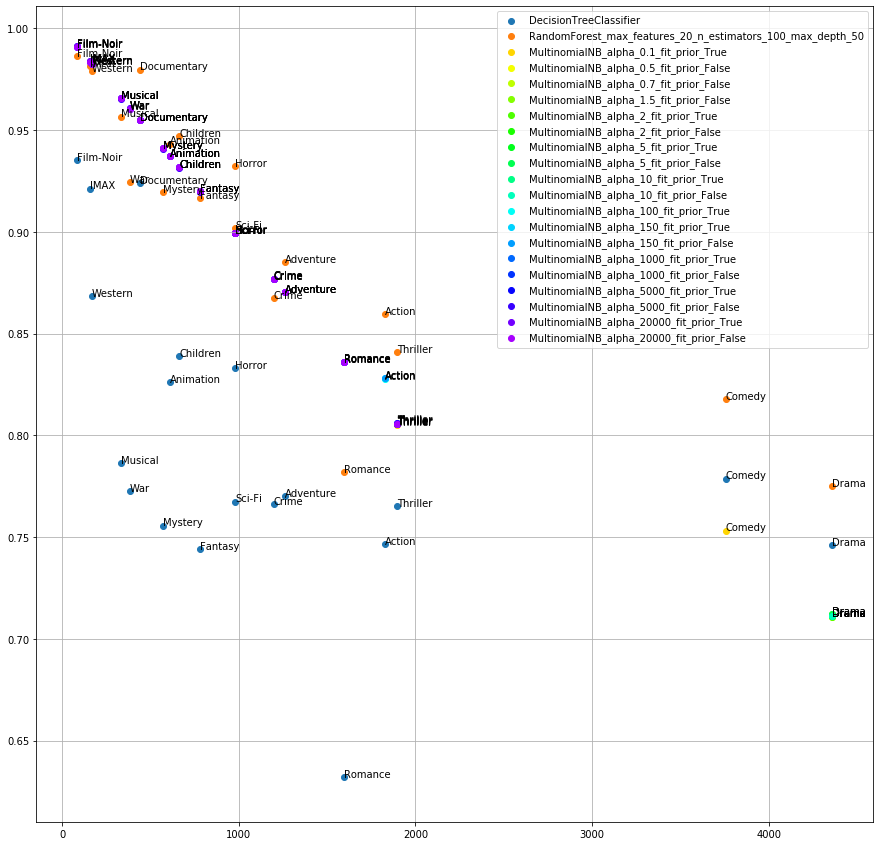

In [59]:
axs = plt.subplots(figsize=(15, 15))
cmap = matplotlib.cm.get_cmap('hsv')

plot_results(plot_data["DecisionTreeClassifier"], axs, "DecisionTreeClassifier")
plot_results(plot_data["RandomForest_max_features_20_n_estimators_100_max_depth_50"], axs, "RandomForest_max_features_20_n_estimators_100_max_depth_50")
nb_plot_data = {k: plot_data[k] for k in plot_data if "MultinomialNB_" in k}
best_nb = {
    g:[
        plot_data["DecisionTreeClassifier"][g][0],
        np.max([nb_plot_data[test][g][1] for test in nb_plot_data])
    ] 
    for g in genres
}
i=4
for name in nb_plot_data:
    chosen_data = {
        g: plot_data[name][g] 
        for g in plot_data[name] 
        if np.abs(plot_data[name][g][1] - best_nb[g][1]) / best_nb[g][1] < 0.002
    }
    color = cmap(i/28.)
    if len(chosen_data) > 0:
        plot_results(chosen_data, axs, name, color=[color])
        i += 1

axs[1].legend()
axs[1].grid(True)

After limitation alpha to 5 we have worse results, but at least they are not on one line, so it brings us hope it will work better in the real live

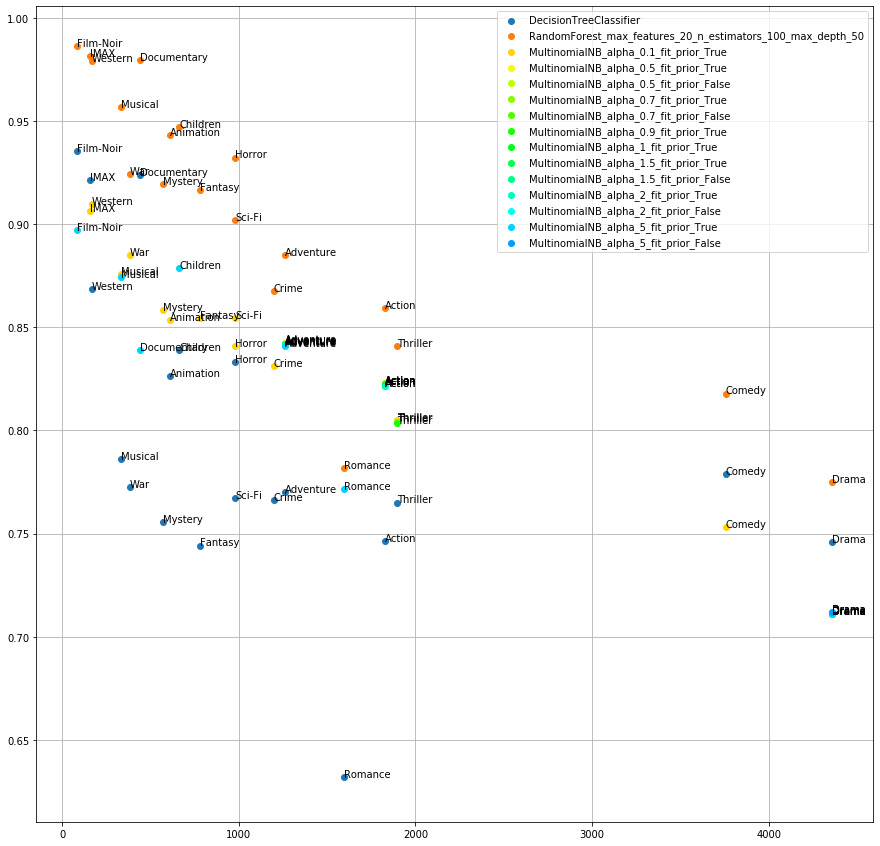

In [60]:
axs = plt.subplots(figsize=(15, 15))
cmap = matplotlib.cm.get_cmap('hsv')

plot_results(plot_data["DecisionTreeClassifier"], axs, "DecisionTreeClassifier")
plot_results(plot_data["RandomForest_max_features_20_n_estimators_100_max_depth_50"], axs, "RandomForest_max_features_20_n_estimators_100_max_depth_50")
nb_plot_data = {k: plot_data[k] for k in plot_data if "MultinomialNB_" in k and "0_" not in k}
best_nb = {
    g:[
        plot_data["DecisionTreeClassifier"][g][0],
        np.max([nb_plot_data[test][g][1] for test in nb_plot_data])
    ] 
    for g in genres
}
i=4
for name in nb_plot_data:
    chosen_data = {
        g: plot_data[name][g] 
        for g in plot_data[name] 
        if np.abs(plot_data[name][g][1] - best_nb[g][1]) / best_nb[g][1] < 0.002
    }
    color = cmap(i/28.)
    if len(chosen_data) > 0:
        plot_results(chosen_data, axs, name, color=[color])
        i += 1

axs[1].legend()
axs[1].grid(True)

## AdaBoostClassifier
The last classifier I tried was AdaBoostClassifier. An AdaBoost classifier is a meta-estimator that begins by fitting 
a classifier on the original dataset and then fits additional copies of the
classifier on the same dataset but where the weights of incorrectly
classified instances are adjusted such that subsequent classifiers focus
more on difficult cases.
I have experimented with different values of parameters: `learning_rate` and `n_estimators`.

In [ ]:
tmp_genres = list(genres)
for learning_rate in [0.1, 0.5, 0.9, 1., 1.5, 5, 10, 50]:
    name = f"AdaBoost_learning_rate_{learning_rate}"
    plot_data[name]=test_classifier(
        AdaBoostClassifier,
        Tree_data,
        tmp_genres,
        clf_name=name,
        verbose=False,
        plot=False,
        cv_n_jobs=-1,
        random_state=7,
        learning_rate=learning_rate
    )
    with open('plot_data.pickle', 'wb') as handle:
        pickle.dump(plot_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

for n_estimators in [5, 10, 50, 100, 500, 1000]:
    name = f"AdaBoost_n_estimators_{n_estimators}"
    plot_data[name]=test_classifier(
        AdaBoostClassifier,
        Tree_data,
        tmp_genres,
        clf_name=name,
        verbose=False,
        plot=False,
        cv_n_jobs=-1,
        random_state=7,
        n_estimators=n_estimators
    )
    with open('plot_data.pickle', 'wb') as handle:
        pickle.dump(plot_data, handle, protocol=pickle.HIGHEST_PROTOCOL)




As we can see, the results are very similar to RandomForestClassifier. The best score gives learning rate 0.5 - 0.9 and n_estimators around 50

AdaBoost_learning_rate_0.1: 7
AdaBoost_learning_rate_0.5: 14
AdaBoost_learning_rate_0.9: 11
AdaBoost_learning_rate_1.0: 12
AdaBoost_learning_rate_1.5: 1
AdaBoost_learning_rate_50: 6
AdaBoost_n_estimators_5: 6
AdaBoost_n_estimators_10: 6
AdaBoost_n_estimators_50: 12
AdaBoost_n_estimators_100: 8


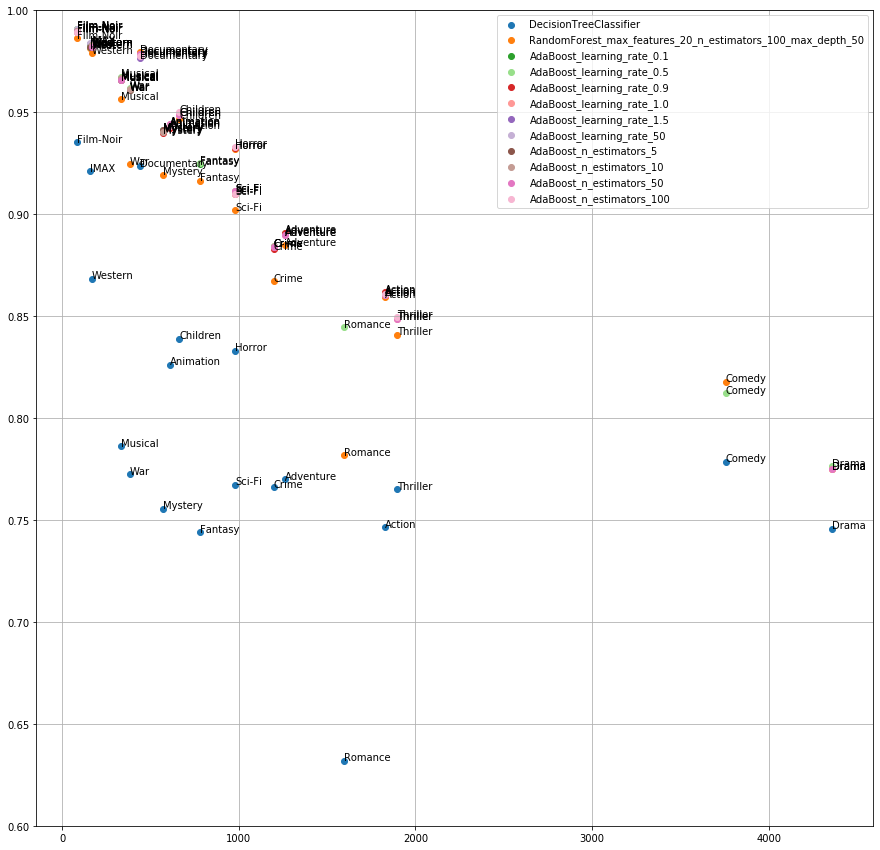

In [75]:
axs = plt.subplots(figsize=(15, 15))
cmap = matplotlib.cm.get_cmap('tab20')

plot_results(plot_data["DecisionTreeClassifier"], axs, "DecisionTreeClassifier")
plot_results(plot_data["RandomForest_max_features_20_n_estimators_100_max_depth_50"], axs, "RandomForest_max_features_20_n_estimators_100_max_depth_50")

ab_plot_data = {k: plot_data[k] for k in plot_data if "AdaBoost" in k and 'test' not in k}
best_ab = {
    g:[
        plot_data["DecisionTreeClassifier"][g][0],
        np.max([ab_plot_data[test][g][1] for test in ab_plot_data])
    ] 
    for g in genres
}
i=4
for name in ab_plot_data:
    chosen_data = {
        g: plot_data[name][g] 
        for g in plot_data[name] 
        if np.abs(plot_data[name][g][1] - best_ab[g][1]) / best_ab[g][1] < 0.002
    }
    color = cmap(i/20)
    if len(chosen_data) > 0:
        print(f"{name}: {len(chosen_data)}")
        plot_results(chosen_data, axs, name, color=[color])
        i += 1

axs[1].set_ylim(0.6, 1)
axs[1].legend()
axs[1].grid(True)

# Summary
There is a trend, that the more movies we have, the lower accuracy we can get. This is reasonable, because more movies in genre means bigger differences between them (and it is harder to classify them).
The one interesting case is "Romans" - it had the worse score in DecisionTree and it got a huge improvement thanks to AdaBoost.
There are two general conclusion: 
    - in my case naive Bayes is better then decision tree, 
    - Adaboost is better with smaller categories (number of true positives  much less then true negatives) and random forest is better with bigger categories)

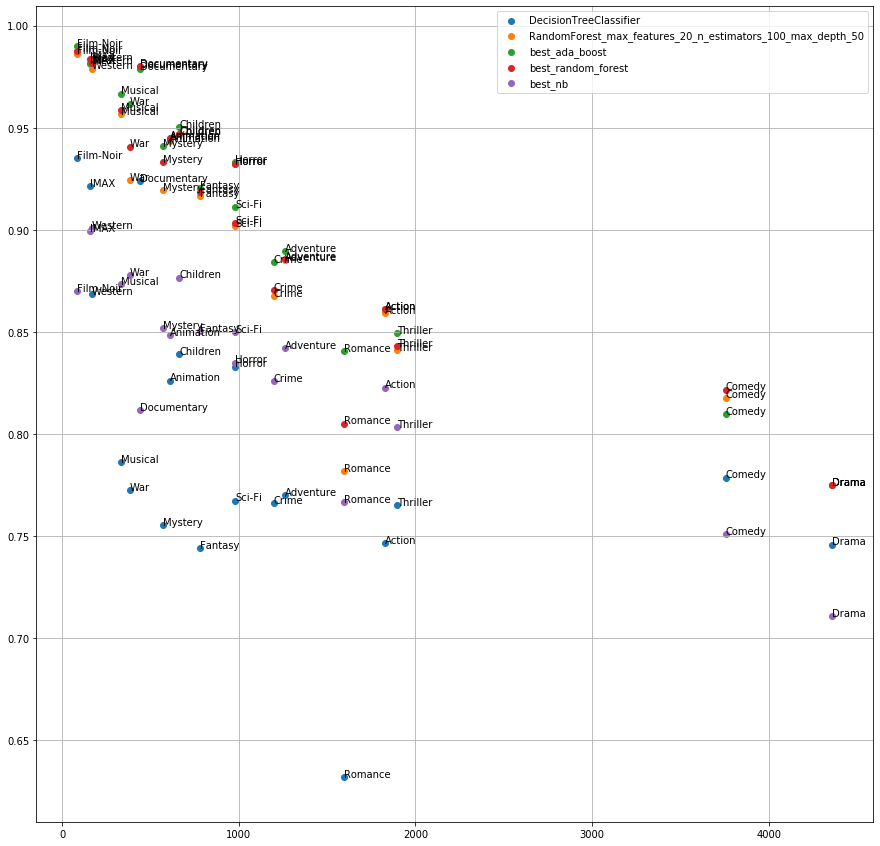

In [62]:
axs = plt.subplots(figsize=(15, 15))


nb_plot_data = {k: plot_data[k] for k in plot_data if "AdaBoost" in k and "estimators" in k}
best_ada_boost = {
    g:[
        plot_data["DecisionTreeClassifier"][g][0], 
        np.max(
            [
                nb_plot_data[test][g][1] 
                for test in nb_plot_data
            ]
        )
    ]
    for g in genres
}
best_random_forest = {
    g:[
        plot_data["DecisionTreeClassifier"][g][0],
        np.max([plot_data[test][g][1] for test in plot_data if 'RandomForest' in test])
    ] 
    for g in genres
}

best_nb = {
    g:[
        plot_data["DecisionTreeClassifier"][g][0],
        np.max([plot_data[test][g][1] for test in plot_data if 'MultinomialNB_alpha_0.5' in test])
    ] 
    for g in genres
}

plot_results(plot_data["DecisionTreeClassifier"], axs, "DecisionTreeClassifier")
plot_results(plot_data["RandomForest_max_features_20_n_estimators_100_max_depth_50"], axs, "RandomForest_max_features_20_n_estimators_100_max_depth_50")
plot_results(best_ada_boost, axs, "best_ada_boost")
plot_results(best_random_forest, axs, "best_random_forest")
plot_results(best_nb, axs, "best_nb")
axs[1].legend()
axs[1].grid(True)


In [24]:
plot_data["Presentation_MultinomialNB"] = best_nb
plot_data["Presentation_Best_random_forest"] = best_random_forest
plot_data["Presentation_Best_best_ada_boost"] = best_ada_boost
with open('plot_data.pickle', 'wb') as handle:
    pickle.dump(plot_data, handle, protocol=pickle.HIGHEST_PROTOCOL)



In [25]:
from datetime import datetime
with open(f'backup/plot_data_dump_{datetime.now()}.pickle', 'wb') as handle:
    pickle.dump(plot_data, handle, protocol=pickle.HIGHEST_PROTOCOL)